# Knee Quantification Workbook (@ Peak Knee Flexion)

__Author__: Steven Hirsch  
__Date__: August 30, 2019

Scroll down to section 3 to bypass all the code at the top

## 1. Packages

In [1]:
import pandas as pd
import numpy as np
from math import pi
from matplotlib import pyplot as plt
from ipywidgets import interact
import seaborn as sns
import pingouin as pg

from IPython.display import HTML

## 2. Functions

### 2.1 Three-Dimensional Distance of Knee Joint Center from Plane Created by Hip and Foot

In [2]:
def plane_distance(midfoot_x, midfoot_y, midfoot_z, ankle_x, ankle_y, ankle_z, knee_x, knee_y, knee_z, hip_x, hip_y, hip_z, side):
    
    '''Create Vectors from Ankle-Foot, Ankle-Hip, and Ankle-Knee'''
    AF_X = midfoot_x - ankle_x
    AF_Y = midfoot_y - ankle_y
    AF_Z = midfoot_z - ankle_z
    AT_X = hip_x - ankle_x
    AT_Y = hip_y - ankle_y
    AT_Z = hip_z - ankle_z
    AK_X = knee_x - ankle_x
    AK_Y = knee_y - ankle_y
    AK_Z = knee_z - ankle_z
    
    '''Vector algebra to quantify i,j,k components of vector perpendicular to plane created by previous vectors'''
    '''Conditional statement used to point normal vector in lateral direction'''
    if (side == "right"):
        Plane_i = (AF_Y*AT_Z - AF_Z*AT_Y)
        Plane_j = (-AF_X*AT_Z + AF_Z*AT_X)
        Plane_k = (AF_X*AT_Y - AF_Y*AT_X)
    else:
        Plane_i = (AF_Y*AT_Z - AF_Z*AT_Y)*-1
        Plane_j = (-AF_X*AT_Z + AF_Z*AT_X)*-1
        Plane_k = (AF_X*AT_Y - AF_Y*AT_X)*-1
    
    '''Vector projection (dot product) to determine 'how much' distance the knee is medial/lateral to plane'''
    '''Equation is in simplified form'''
    length_proj = (Plane_i*AK_X + Plane_j*AK_Y + Plane_k*AK_Z) / np.sqrt(Plane_i**2+Plane_j**2+Plane_k**2)
    
    return length_proj

### 2.2 Two-Dimensional Distance of Knee Joint Center from Line Spanning Hip and Foot

In [3]:
def line_distance(midfoot_y, midfoot_z, ankle_y, ankle_z, knee_y, knee_z, hip_y, hip_z, side):
    
    '''Create y and z components (frontal plane of coordinate system) of line spanning hip and foot'''
    line_y = hip_y - midfoot_y
    line_z = hip_z - midfoot_z
    
    '''Create y and z components of line perpendicular to the previous (using the negative inverse slope)'''
    perp_line_y = line_z * -1
    perp_line_z = line_y * -1
    
    '''Create vector from Foot-Knee'''
    knee_vect_y = knee_y - midfoot_y
    knee_vect_z = knee_z - midfoot_z
    
    '''Project knee vector onto perpendicular line and calculate its magnitude'''
    projection = (perp_line_y*knee_vect_y + perp_line_z*knee_vect_z) / (perp_line_y**2 + perp_line_z**2)
    
    projection_length_y = projection * perp_line_y
    projection_length_z = projection * perp_line_z
    projection_length = np.sqrt(projection_length_y**2+projection_length_z**2)
    
    d = line_y*knee_vect_z - knee_vect_y*line_z
    
    '''Conditional statement so points on 'valgus' side of line are represented by negative distance and varus positive'''
    projection_length = np.array(projection_length)
    d= np.array(d)
    if(side == 'right'):
        return np.where(d<0, projection_length*-1, projection_length)
    else:
        return np.where(d>0, projection_length*-1, projection_length)

### 2.3 Separation Ratio for Knee-Ankle Separation Ratio (KASR) and Knee-Foot Separation Ratio (KFSR)

In [4]:
def sep_ratio(right_y, left_y, Rknee_y, Lknee_y):
    ratio = abs(Rknee_y - Lknee_y)/ abs(right_y - left_y)
    return(ratio)

### 2.4 Two-Dimensional Rotation Angle (Superior View of Transverse Plane)

In [5]:
def ext_rot_angle (distal_x, distal_y, proximal_x, proximal_y, side):
    '''Define x and y coordinates of segment'''
    segment_x = distal_x - proximal_x
    segment_y = distal_y - proximal_y
    
    '''Quantify angle (in radians, using arctan2) segment is rotated in superior view/transverse plane'''
    '''Conditional Statement so positive values are 'external rotation', 'negative values internal rotation' '''
    if(side == "left"):
        angle = np.arctan2(segment_y, segment_x)*180/pi
    else :
        angle = np.arctan2(segment_y, segment_x)*180/pi*-1
    
    return(angle)


### 2.5 Creation of DataFrame

In [6]:
def create_df(data):
    df = pd.DataFrame({
    'Rep': data.Rep,
    
    'L_3D_Proj': plane_distance(data.L_Midfoot_X, data.L_Midfoot_Y, data.L_Midfoot_Z, data.L_Ankle_X,data.L_Ankle_Y, data.L_Ankle_Z, data.L_Knee_X, data.L_Knee_Y,data.L_Knee_Z, data.L_Hip_X, data.L_Hip_Y, data.L_Hip_Z, side = "left"),
    'L_2D_Proj': line_distance(data.L_Midfoot_Y, data.L_Midfoot_Z, data.L_Ankle_Y, data.L_Ankle_Z,data.L_Knee_Y,data.L_Knee_Z,data.L_Hip_Y, data.L_Hip_Z, side = "left"),
    'L_Cardan_Angle': data.L_KneeAngle_X,
    'L_FT_Ratio': ext_rot_angle(data.L_Knee_X, data.L_Knee_Y, data.L_Hip_X, data.L_Hip_Y, side = "left")/ext_rot_angle(data.L_Midfoot_X, data.L_Midfoot_Y, data.L_Ankle_X, data.L_Ankle_Y, side = "left"),
    
    'R_3D_Proj': plane_distance(data.R_Midfoot_X, data.R_Midfoot_Y, data.R_Midfoot_Z, data.R_Ankle_X,data.R_Ankle_Y, data.R_Ankle_Z, data.R_Knee_X, data.R_Knee_Y,data.R_Knee_Z, data.R_Hip_X, data.R_Hip_Y, data.R_Hip_Z, side = "right"),
    'R_2D_Proj': line_distance(data.R_Midfoot_Y, data.R_Midfoot_Z, data.R_Ankle_Y, data.R_Ankle_Z,data.R_Knee_Y,data.R_Knee_Z,data.R_Hip_Y, data.R_Hip_Z, side = "right"),
    'R_Cardan_Angle': data.R_KneeAngle_X,
    'R_FT_Ratio': ext_rot_angle(data.R_Knee_X, data.R_Knee_Y, data.R_Hip_X, data.R_Hip_Y, side = "right")/ext_rot_angle(data.R_Midfoot_X, data.R_Midfoot_Y, data.R_Ankle_X, data.R_Ankle_Y, side = "right"),
    
    'KASR': sep_ratio(data.R_Ankle_Y, data.L_Ankle_Y, data.R_Knee_Y, data.L_Knee_Y),
    'KFSR': sep_ratio(data.R_Midfoot_Y, data.L_Midfoot_Y, data.R_Knee_Y, data.L_Knee_Y)
})
    return df

### 2.6 Dictionary of DataFrame

In [7]:
def make_dict(data):
    dict = {
        'L_3D_Proj': data.L_3D_Proj,
        'R_3D_Proj': data.R_3D_Proj,
        'L_2D_Proj': data.L_2D_Proj,
        'R_2D_Proj': data.R_2D_Proj,
        'L_Cardan_Angle': data.L_Cardan_Angle,
        'R_Cardan_Angle': data.R_Cardan_Angle,
        'L_FT_Ratio': data.L_FT_Ratio,
        'R_FT_Ratio': data.R_FT_Ratio,
        'KASR': data.KASR,
        'KFSR': data.KFSR
    }
    return dict

### 2.7 Valgus-Varus Interpretation of Data

In [8]:
def eval_prop(data, x):
    prop = sum(data<x)/airsquat.shape[0]*100
    return prop
'''Use this for grid searching'''
def evaluate_interpretation_prop(data):
    '''feel free to adjust the default cutoff values'''
    '''The intial plots help to tell a story, but a proper grid search will require functions and not visuals'''
    proj_3d_cutoffs = [0, -0.10]
    proj_2d_cutoffs = [0,0.10]
    cardan_cutoffs = [0, 25]
    ft_cutoffs = [1, 0.6]
    kasr_cutoffs = ft_cutoffs
    kfsr_cutoffs = ft_cutoffs

    for a in proj_3d_cutoffs:
        for b in proj_2d_cutoffs:
            for c in cardan_cutoffs:
                for d in ft_cutoffs:
                    for e in kasr_cutoffs:
                        for f in kfsr_cutoffs:
                            print('3D Proj Cutoff: ' + str(a))
                            print('2D Proj Cutoff: ' + str(b))
                            print('Cardan Angle Cutoff: ' + str(c))
                            print('Foot-Thigh Ratio: ' + str(d))
                            print('KASR Cutoff: ' + str(e))
                            print('KFSR Cutoff: ' + str(f))
                            print('')

                            R_proj_3d = eval_prop(data.R_3D_Proj,a)
                            R_proj_2d = eval_prop(data.R_2D_Proj,b)
                            R_cardan = eval_prop(data.R_Cardan_Angle,c)
                            R_ft_ratio = eval_prop(data.R_FT_Ratio,d)
                            kasr = eval_prop(data.KASR,e)
                            kfsr = eval_prop(data.KFSR,f)
                            L_proj_3d = eval_prop(data.L_3D_Proj,a)
                            L_proj_2d = eval_prop(data.L_2D_Proj,b)
                            L_cardan = eval_prop(data.L_Cardan_Angle,c)
                            L_ft_ratio = eval_prop(data.L_FT_Ratio,d)

                            metrics = [R_proj_3d, R_proj_2d,R_cardan, R_ft_ratio, kasr, kfsr, L_proj_3d, L_proj_2d, L_cardan, L_ft_ratio]
                            names = ['R_3D_Proj', 'R_2D_Proj', 'R_Cardan_Angle', 'R_FT_Ratio', 'KASR', 'KFSR', 'L_3D_Proj', 'L_2D_Proj', 'L_Cardan_Angle', 'L_FT_Ratio']

                            plt.bar(names, metrics)
                            plt.xlabel('Metric')
                            plt.xticks(rotation=90)
                            plt.ylabel('Proportion of Valgus (%)')
                            plt.show()

### 2.8 Repeated Measures Correlation Matrix

In [9]:
def rm_corr_matrix(data):
    '''Fair warning, this is not a very elegant way of doing this, but it was the only way I got it to work'''
    corr_matrix = data.corr()
    index_1 = [0,1,2,3,4,5,6,7,8,9]
    index_2 = [0,1,2,3,4,5,6,7,8,9]
    variables = airsquat_plot.columns
    metrics= variables[1:] 

    for a in index_1:
        for b in index_2:
            if a == b:
                r = 1.
                #print()
            else:
                r = round(pg.rm_corr(data=data, x=metrics[a], y=metrics[b], subject='PID').iloc[0,0],2)
                #print()

            #print('Var1= ' + str(metrics[a]) + ' | Var2= ' + str(metrics[b]) + ' | RM Corr= ' + str(r))
            corr_matrix.iloc[a,b] = r
    return corr_matrix

### 2.9 Correlation Heatmap Figure

In [10]:
def corr_heatmap(data):
    corr = rm_corr_matrix(data)
    sns.heatmap(corr, cmap= 'Blues', annot= True)
    plt.show()

### 2.10 Agreement Plot

In [11]:
def agreement_plot(var1, var2, var1_threshold_to_iterate, var2_threshold_constant):
    '''The inputs are inelegant, but works for the exploration purposes here'''
    var1_cutoffs= var1_threshold_to_iterate
    cutoff = []
    prop_agree = []
    for i in range(var1_cutoffs):
        cutoff.append(i),
        prop_agree.append(sum(np.logical_and(var2 < var2_threshold_constant, var1 < i))/var1.shape[0]*100)
        
    agreement_df = pd.DataFrame({"Threshold": cutoff, "Prop_Agree": prop_agree})
    #xaxis= 'Threshold of '+ input('Type var1: ')
    #yaxis= 'Proportion of Agreement with ' + input("Type var2: ")
    plt.plot(agreement_df.Threshold, agreement_df.Prop_Agree)
    plt.xlabel('Threshold')
    plt.ylabel('Proportion of Agreement')
    #plt.title('3D Projection Distance and Cardan Angle')
    plt.show()

## 3. Data Preprocessing

### 3.1 Data Import

In [12]:
airsquat_data = pd.read_csv('airsquat_peak_workbook.csv')
airsquat_data.L_KneeAngle_X = airsquat_data.L_KneeAngle_X * -1
airsquat_data.set_index('PID', inplace= True)

jumpsquat_data = pd.read_csv('Jumpsquat_peak_workbook.csv')
jumpsquat_data.L_KneeAngle_X = jumpsquat_data.L_KneeAngle_X * -1
jumpsquat_data.set_index('PID', inplace= True)

### 3.2 Basic Summary Statistics

In [13]:
airsquat = create_df(airsquat_data)
airsquat_dict = make_dict(airsquat)

jumpsquat = create_df(jumpsquat_data)
jumpsquat_dict = make_dict(jumpsquat)

### 3.2.1 Airsquat Data Summary

In [14]:
airsquat.describe()

,Rep,L_3D_Proj,L_2D_Proj,L_Cardan_Angle,L_FT_Ratio,R_3D_Proj,R_2D_Proj,R_Cardan_Angle,R_FT_Ratio,KASR,KFSR
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,5.500000,-0.089180,0.058339,4.662453,0.535681,-0.118191,0.059415,4.034272,0.437486,1.231320,0.977613
std,2.877821,0.077680,0.050610,4.533340,0.364830,0.067932,0.055507,5.858293,0.263345,0.230024,0.134141
min,1.000000,-0.295344,-0.106996,-2.884809,-0.602007,-0.313302,-0.121245,-10.419755,-0.265517,0.814157,0.686955
25%,3.000000,-0.137602,0.017916,1.436487,0.293222,-0.165266,0.025739,0.894237,0.269618,1.042852,0.873381
50%,5.500000,-0.069404,0.064266,3.630702,0.497943,-0.109656,0.069531,4.222034,0.450520,1.186357,0.971103
75%,8.000000,-0.028450,0.098713,6.894351,0.774123,-0.066733,0.095956,8.202140,0.605478,1.391525,1.051187
max,10.000000,0.028492,0.146284,17.068478,2.533397,0.036518,0.156589,14.504962,1.253214,1.759355,1.308892


### 3.2.1 Jumpsquat Data Summary

In [15]:
jumpsquat.describe()

,Rep,L_3D_Proj,L_2D_Proj,L_Cardan_Angle,L_FT_Ratio,R_3D_Proj,R_2D_Proj,R_Cardan_Angle,R_FT_Ratio,KASR,KFSR
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,5.500000,-0.104009,0.043213,5.731072,0.351696,-0.129222,0.048463,4.974784,0.272318,1.088897,0.864192
std,2.877821,0.063641,0.092103,4.263714,0.244409,0.057158,0.082155,4.731352,0.254814,0.172601,0.112224
min,1.000000,-0.310640,-0.210407,-4.628514,-0.398587,-0.319594,-0.158548,-5.523571,-1.149898,0.733155,0.594736
25%,3.000000,-0.128866,0.006249,2.904208,0.202370,-0.170484,0.021202,2.141924,0.166103,0.946120,0.779552
50%,5.500000,-0.094689,0.062478,5.834250,0.344900,-0.119907,0.069700,4.402318,0.318650,1.054125,0.857720
75%,8.000000,-0.058973,0.098787,7.910238,0.482620,-0.083884,0.102445,7.925249,0.435792,1.204081,0.950322
max,10.000000,0.030336,0.207982,18.626230,1.266523,-0.028847,0.238335,15.227469,0.738442,1.572166,1.099360


# 4.  Assessing Metrics

## 4.1 Relationship Between Various Knee Quantification Metrics

### 4.1.1 Airsquat

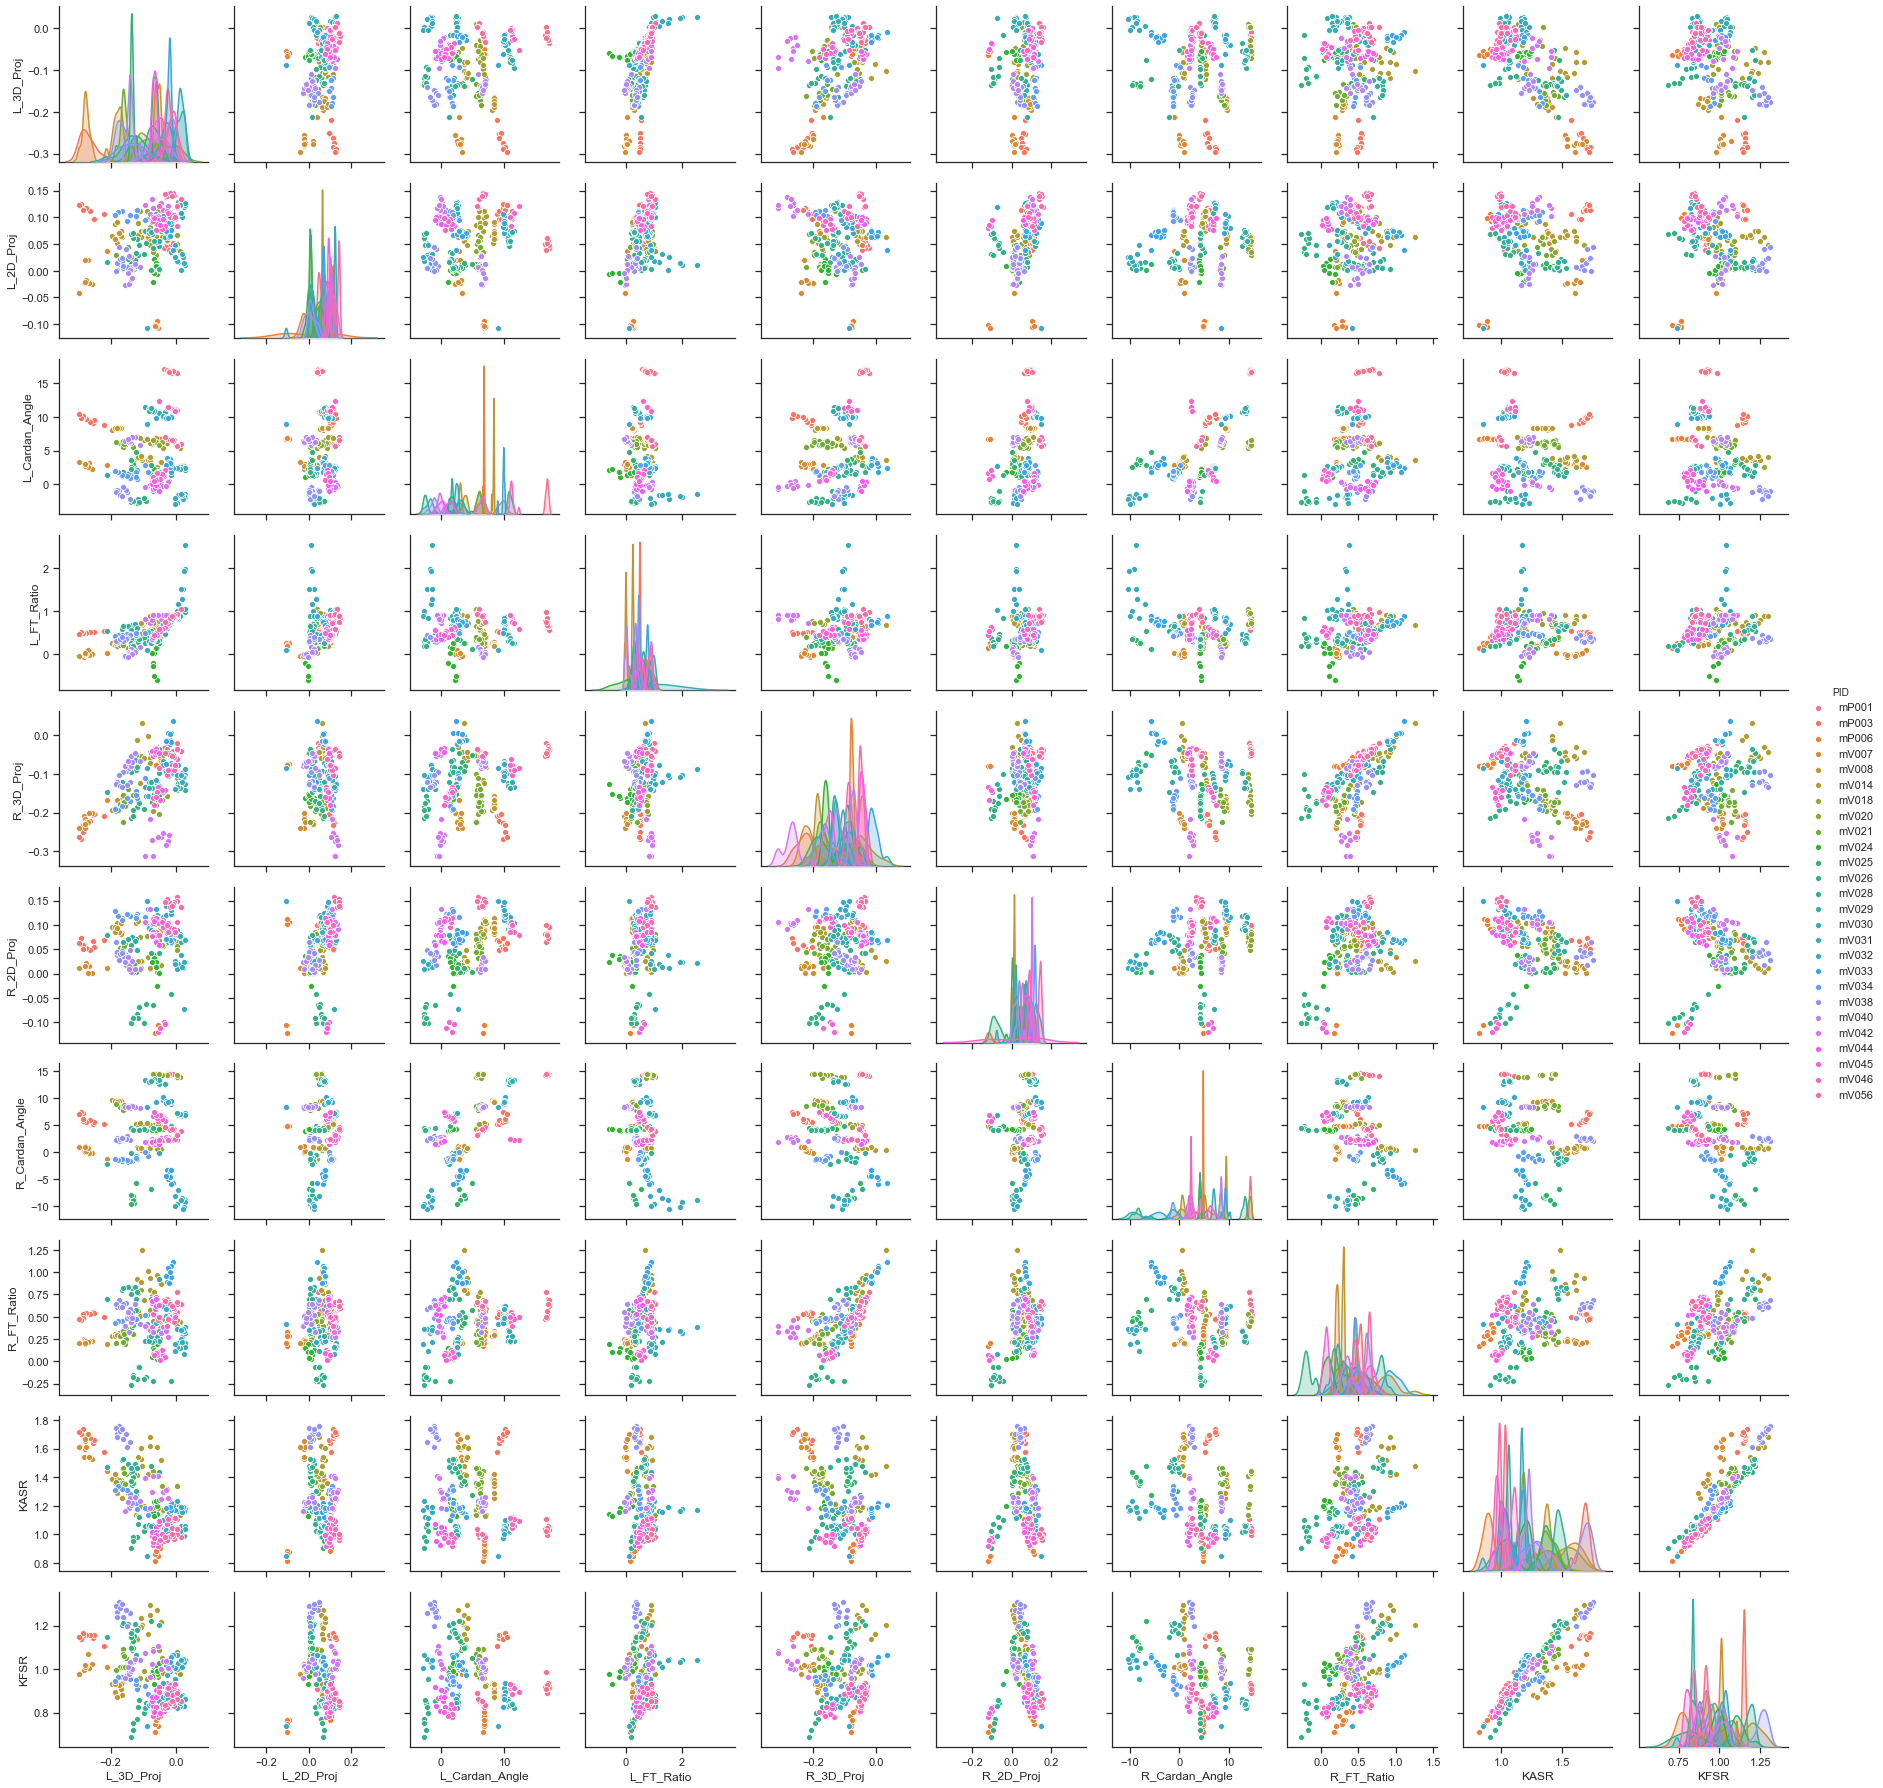

In [16]:
airsquat_plot = airsquat.drop('Rep', axis =1).reset_index()
sns.pairplot(airsquat_plot, hue= 'PID')

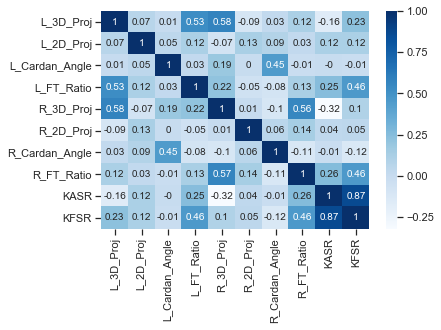

In [17]:
corr_heatmap(airsquat_plot)

### 4.1.2 Jumpsquat

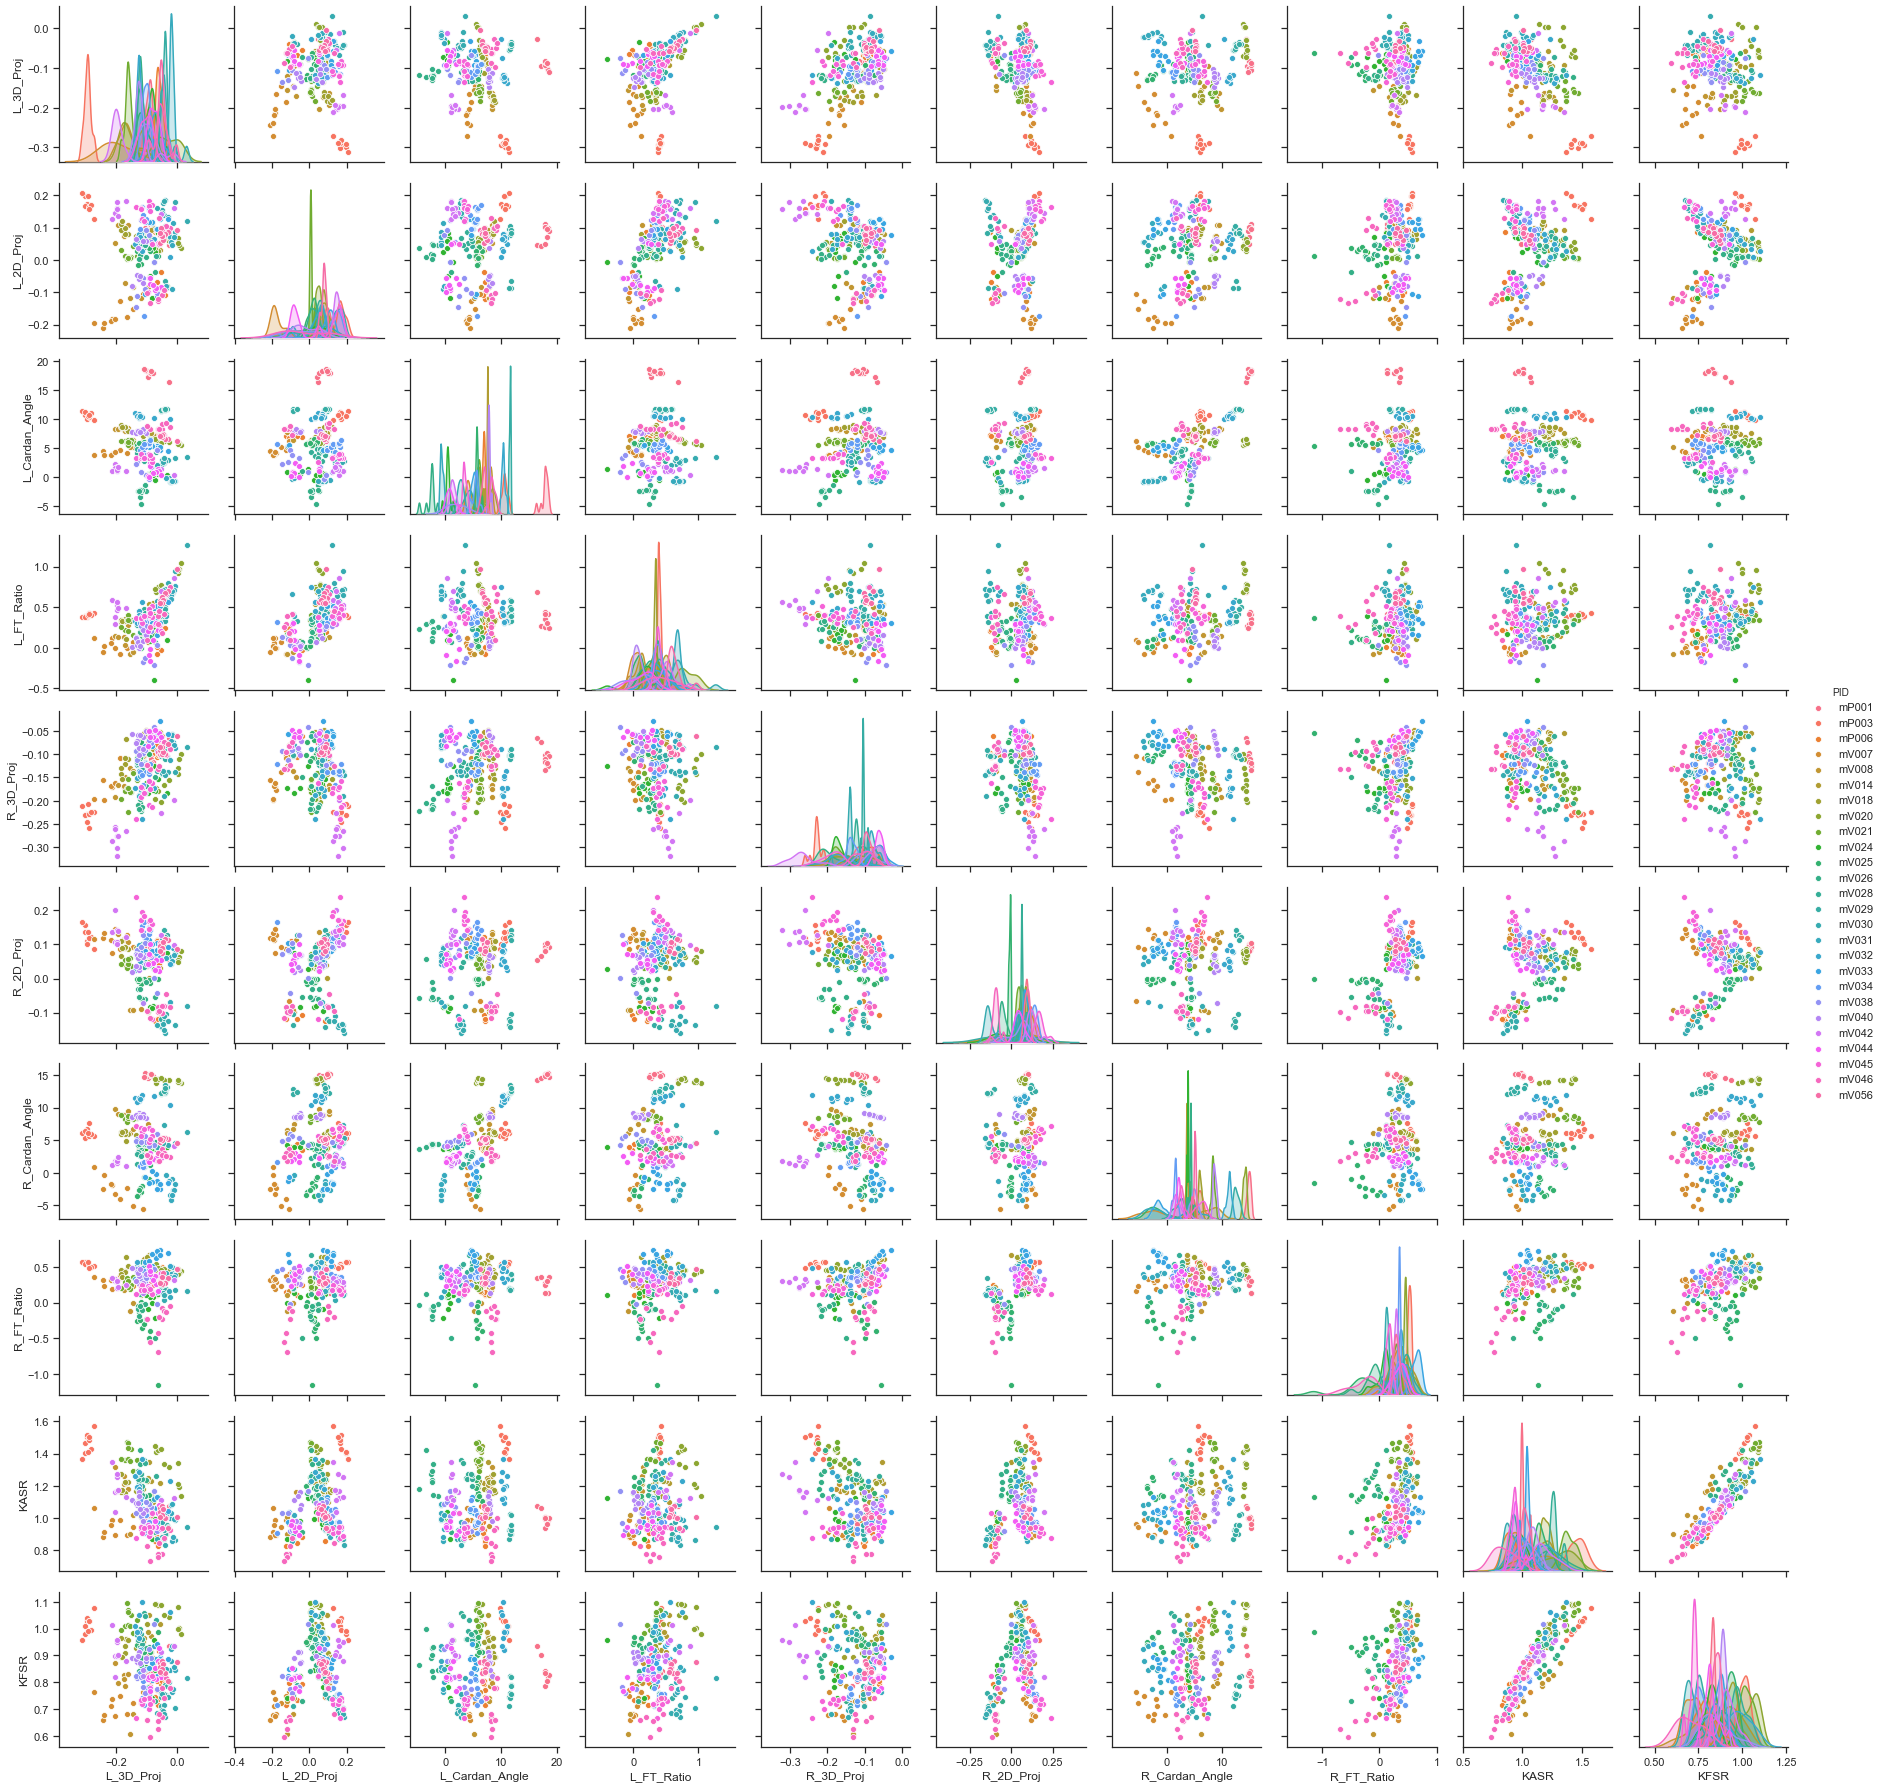

In [18]:
jumpsquat_plot = jumpsquat.drop('Rep', axis =1).reset_index()
sns.pairplot(jumpsquat_plot, hue= 'PID')

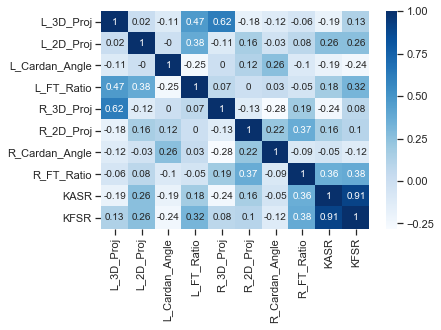

In [19]:
corr_heatmap(jumpsquat_plot)

## 4.2 Proportion of Knee Valgus with Various Thresholds

An important caveat to below is that we are assessing the propotion/interpretation of these metrics under the assumption that valgus is now __BINARY__ (i.e. either someone's knee is valgus, or it isn't).

#### 4.2.1 Aggregated

Please feel free to play around with some of the plots below to get a sense of how different thresholds might influence the proportion of total valgus and varus decisions. To be clear, anything below the threshold is considered valgus and this is just lumping all the data together, __NOT__ assessing each repetition individually.

In [20]:
@interact
def interact_plot(proj_3d_cutoffs = (-0.2,0.2, 0.01), 
                                 proj_2d_cutoffs = (-0.2,0.2, 0.01),
                                 cardan_cutoffs = (-25.,25., 1),
                                 ft_cutoffs = (0.25,2., 0.125),
                                 kasr_cutoffs = (0.25,2., 0.125), 
                                 kfsr_cutoffs = (0.25,2., 0.125)):
    
    R_proj_3d = eval_prop(airsquat.R_3D_Proj,proj_3d_cutoffs)
    R_proj_2d = eval_prop(airsquat.R_2D_Proj,proj_2d_cutoffs)
    R_cardan = eval_prop(airsquat.R_Cardan_Angle,cardan_cutoffs)
    R_ft_ratio = eval_prop(airsquat.R_FT_Ratio,ft_cutoffs)
    kasr = eval_prop(airsquat.KASR,kasr_cutoffs)
    kfsr = eval_prop(airsquat.KFSR,kfsr_cutoffs)
    L_proj_3d = eval_prop(airsquat.L_3D_Proj,proj_3d_cutoffs)
    L_proj_2d = eval_prop(airsquat.L_2D_Proj,proj_2d_cutoffs)
    L_cardan = eval_prop(airsquat.L_Cardan_Angle,cardan_cutoffs)
    L_ft_ratio = eval_prop(airsquat.L_FT_Ratio,ft_cutoffs)

    metrics = [R_proj_3d, R_proj_2d,R_cardan, R_ft_ratio, kasr, kfsr, L_proj_3d, L_proj_2d, L_cardan, L_ft_ratio]
    names = ['R_3D_Proj', 'R_2D_Proj', 'R_Cardan_Angle', 'R_FT_Ratio', 'KASR', 'KFSR', 'L_3D_Proj', 'L_2D_Proj', 'L_Cardan_Angle', 'L_FT_Ratio']

    plt.bar(names, metrics)
    plt.title('Airsquat')
    plt.xlabel('Metric')
    plt.xticks(rotation=90)
    plt.ylabel('Proportion of Valgus (%)')
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='proj_3d_cutoffs', max=0.2, min=-0.2, step=0.01), Flo…

In [21]:
@interact
def interact_plot(proj_3d_cutoffs = (-0.2,0.2, 0.01), 
                                 proj_2d_cutoffs = (-0.2,0.2, 0.01),
                                 cardan_cutoffs = (-25.,25., 1),
                                 ft_cutoffs = (0.25,2., 0.125),
                                 kasr_cutoffs = (0.25,2., 0.125), 
                                 kfsr_cutoffs = (0.25,2., 0.125)):
    
    R_proj_3d = eval_prop(jumpsquat.R_3D_Proj,proj_3d_cutoffs)
    R_proj_2d = eval_prop(jumpsquat.R_2D_Proj,proj_2d_cutoffs)
    R_cardan = eval_prop(jumpsquat.R_Cardan_Angle,cardan_cutoffs)
    R_ft_ratio = eval_prop(jumpsquat.R_FT_Ratio,ft_cutoffs)
    kasr = eval_prop(jumpsquat.KASR,kasr_cutoffs)
    kfsr = eval_prop(jumpsquat.KFSR,kfsr_cutoffs)
    L_proj_3d = eval_prop(jumpsquat.L_3D_Proj,proj_3d_cutoffs)
    L_proj_2d = eval_prop(jumpsquat.L_2D_Proj,proj_2d_cutoffs)
    L_cardan = eval_prop(jumpsquat.L_Cardan_Angle,cardan_cutoffs)
    L_ft_ratio = eval_prop(jumpsquat.L_FT_Ratio,ft_cutoffs)

    metrics = [R_proj_3d, R_proj_2d,R_cardan, R_ft_ratio, kasr, kfsr, L_proj_3d, L_proj_2d, L_cardan, L_ft_ratio]
    names = ['R_3D_Proj', 'R_2D_Proj', 'R_Cardan_Angle', 'R_FT_Ratio', 'KASR', 'KFSR', 'L_3D_Proj', 'L_2D_Proj', 'L_Cardan_Angle', 'L_FT_Ratio']

    plt.bar(names, metrics)
    plt.title('Jumpsquat')
    plt.xlabel('Metric')
    plt.xticks(rotation=90)
    plt.ylabel('Proportion of Valgus (%)')
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='proj_3d_cutoffs', max=0.2, min=-0.2, step=0.01), Flo…

The main trends that I've seen (included when I did a small grid search, which I did not include here) was that to make these metrics "agree" as a proportion of total interpretations, we either had to accept a large amount of knee valgus with the 3D projection, knee-foot separation ratio, knee-ankle separation ratio, OR we could just say anything under +20deg in the Cardan angle corresponds to knee valgus. I need to double check again what kind of thresholds might be used in the literature. Although this data tempts me to conclude we should adjust our threshold of knee valgus motion if using Cardan angles, this would correspond to ~90% of participants having valgus knees during the airsquat and jump squat. Even though I wouldn't rule that out, especially after seeing the videos again recently, given that we don't have any "ground truth" measurement I don't think it's fair to say anything other than these metrics don't align.

#### 4.2.2 Repetition-By-Repetition Analysis

I've just included some plots below where you can toggle the thresholds for reference as grid searching is too computationally expensive and will take up too much space. Interestingly, we get the best agreement when we allow the 3D projection distance to have >=0 as its threshold, but need to expand the threshold of the Cardan angle to ~15deg in both cases for the interpretations to start lining up.

Again, we run into the issue that the data is basically just interpreting everyone as having 'knee valgus'. Whether or not we're okay with this assumption depends on the kinetics, which we have to evaluate with another dataset. However, after watching the videos I don't think that it is totally unfair to assume almost everyone had valgus knees at peak knee flexion during both the airsquats and jump squats (I don't really trust my eyes, though).

In [65]:
@interact
def agreement_plot_interact(Cardan = (1,50,1),Proj_3d = (-.2,.2,.01)):
    '''The inputs are inelegant, but works for the exploration purposes here'''
    var1_cutoffs= Cardan
    cutoff = []
    prop_agree = []
    for i in range(var1_cutoffs):
        cutoff.append(i),
        prop_agree.append(sum(np.logical_and(airsquat_plot.L_3D_Proj < Proj_3d, 
        airsquat_plot.L_Cardan_Angle < i))/airsquat_plot.L_Cardan_Angle.shape[0]*100)
        
    agreement_df = pd.DataFrame({"Threshold": cutoff, "Prop_Agree": prop_agree})
    #xaxis= 'Threshold of '+ input('Type var1: ')
    #yaxis= 'Proportion of Agreement with ' + input("Type var2: ")
    plt.plot(agreement_df.Threshold, agreement_df.Prop_Agree)
    plt.xlabel('Threshold for Cardan Angle')
    plt.ylabel('Proportion of Agreement with \n 3D Projection Distance (%)')
    plt.title('AIRSQUAT\n 3D Projection Distance and Cardan Angle (Left)')
    plt.show()
    
    both_valgus = sum(np.logical_and(airsquat_plot.L_3D_Proj < Proj_3d, airsquat_plot.L_Cardan_Angle < i))
    both_valgus_percent = round(both_valgus/260*100,2)
    proj_valgus_cardan_not = sum(np.logical_and(airsquat_plot.L_3D_Proj < Proj_3d, airsquat_plot.L_Cardan_Angle > i))
    proj_valgus_cardan_not_percent = round(proj_valgus_cardan_not/260*100,2)
    proj_not_cardan_valgus = sum(np.logical_and(airsquat_plot.L_3D_Proj > Proj_3d, airsquat_plot.L_Cardan_Angle < i))
    proj_not_cardan_valgus_percent = round(proj_not_cardan_valgus/260*100,2)
    both_not_valgus = sum(np.logical_and(airsquat_plot.L_3D_Proj > Proj_3d, airsquat_plot.L_Cardan_Angle > i))
    both_not_valgus_percent = round(both_not_valgus/260*100,2)
    
    total_agreement = both_valgus + both_not_valgus
    total_agreement_percent = both_valgus_percent + both_not_valgus_percent
    total_disagreement = proj_valgus_cardan_not + proj_not_cardan_valgus
    total_disagreement_percent = proj_valgus_cardan_not_percent + proj_not_cardan_valgus_percent
    
    print('Both Valgus: ' + str(both_valgus) + ' ('+ str(both_valgus_percent) + '%)')
    print('3D Proj Valgus, Cardan Not Valgus: ' + str(proj_valgus_cardan_not) + ' ('+ str(proj_valgus_cardan_not_percent) + '%)')
    print('3D Proj Not Valgus, Cardan Valgus: ' + str(proj_not_cardan_valgus) + ' ('+ str(proj_not_cardan_valgus_percent) + '%)')
    print('Both Not Valgus: ' + str(both_not_valgus) + ' ('+ str(both_not_valgus_percent) + '%)')
    print('')
    print('Total Agreement: ' + str(total_agreement) + ' (' + str(total_agreement_percent) + '%)')
    print('Total Disagreement: ' + str(total_disagreement) + ' (' + str(total_disagreement_percent) + '%)')

interactive(children=(IntSlider(value=25, description='Cardan', max=50, min=1), FloatSlider(value=0.0, descrip…

In [66]:
@interact
def agreement_plot_interact(Cardan = (1,50,1),Proj_3d = (-.2,.2,.01)):
    '''The inputs are inelegant, but works for the exploration purposes here'''
    var1_cutoffs= Cardan
    cutoff = []
    prop_agree = []
    for i in range(var1_cutoffs):
        cutoff.append(i),
        prop_agree.append(sum(np.logical_and(airsquat_plot.R_3D_Proj < Proj_3d, 
        airsquat_plot.R_Cardan_Angle < i))/airsquat_plot.R_Cardan_Angle.shape[0]*100)
        
    agreement_df = pd.DataFrame({"Threshold": cutoff, "Prop_Agree": prop_agree})
    #xaxis= 'Threshold of '+ input('Type var1: ')
    #yaxis= 'Proportion of Agreement with ' + input("Type var2: ")
    plt.plot(agreement_df.Threshold, agreement_df.Prop_Agree)
    plt.xlabel('Threshold for Cardan Angle')
    plt.ylabel('Proportion of Agreement with \n 3D Projection Distance (%)')
    plt.title('AIRSQUAT\n 3D Projection Distance and Cardan Angle (Right)')
    plt.show()
    
    both_valgus = sum(np.logical_and(airsquat_plot.R_3D_Proj < Proj_3d, airsquat_plot.R_Cardan_Angle < i))
    both_valgus_percent = round(both_valgus/260*100,2)
    proj_valgus_cardan_not = sum(np.logical_and(airsquat_plot.R_3D_Proj < Proj_3d, airsquat_plot.R_Cardan_Angle > i))
    proj_valgus_cardan_not_percent = round(proj_valgus_cardan_not/260*100,2)
    proj_not_cardan_valgus = sum(np.logical_and(airsquat_plot.R_3D_Proj > Proj_3d, airsquat_plot.R_Cardan_Angle < i))
    proj_not_cardan_valgus_percent = round(proj_not_cardan_valgus/260*100,2)
    both_not_valgus = sum(np.logical_and(airsquat_plot.R_3D_Proj > Proj_3d, airsquat_plot.R_Cardan_Angle > i))
    both_not_valgus_percent = round(both_not_valgus/260*100,2)
    
    total_agreement = both_valgus + both_not_valgus
    total_agreement_percent = both_valgus_percent + both_not_valgus_percent
    total_disagreement = proj_valgus_cardan_not + proj_not_cardan_valgus
    total_disagreement_percent = proj_valgus_cardan_not_percent + proj_not_cardan_valgus_percent
    
    print('Both Valgus: ' + str(both_valgus) + ' ('+ str(both_valgus_percent) + '%)')
    print('3D Proj Valgus, Cardan Not Valgus: ' + str(proj_valgus_cardan_not) + ' ('+ str(proj_valgus_cardan_not_percent) + '%)')
    print('3D Proj Not Valgus, Cardan Valgus: ' + str(proj_not_cardan_valgus) + ' ('+ str(proj_not_cardan_valgus_percent) + '%)')
    print('Both Not Valgus: ' + str(both_not_valgus) + ' ('+ str(both_not_valgus_percent) + '%)')
    print('')
    print('Total Agreement: ' + str(total_agreement) + ' (' + str(total_agreement_percent) + '%)')
    print('Total Disagreement: ' + str(total_disagreement) + ' (' + str(total_disagreement_percent) + '%)')

interactive(children=(IntSlider(value=25, description='Cardan', max=50, min=1), FloatSlider(value=0.0, descrip…

In [67]:
@interact
def agreement_plot_interact(Cardan = (1,50,1),Proj_3d = (-.2,.2,.01)):
    '''The inputs are inelegant, but works for the exploration purposes here'''
    var1_cutoffs= Cardan
    cutoff = []
    prop_agree = []
    for i in range(var1_cutoffs):
        cutoff.append(i),
        prop_agree.append(sum(np.logical_and(jumpsquat_plot.L_3D_Proj < Proj_3d, 
        jumpsquat_plot.L_Cardan_Angle < i))/jumpsquat_plot.L_Cardan_Angle.shape[0]*100)
        
    agreement_df = pd.DataFrame({"Threshold": cutoff, "Prop_Agree": prop_agree})
    #xaxis= 'Threshold of '+ input('Type var1: ')
    #yaxis= 'Proportion of Agreement with ' + input("Type var2: ")
    plt.plot(agreement_df.Threshold, agreement_df.Prop_Agree)
    plt.xlabel('Threshold for Cardan Angle')
    plt.ylabel('Proportion of Agreement with \n 3D Projection Distance (%)')
    plt.title('JUMPSQUAT\n 3D Projection Distance and Cardan Angle (Left)')
    plt.show()
    
    both_valgus = sum(np.logical_and(jumpsquat_plot.L_3D_Proj < Proj_3d, jumpsquat_plot.L_Cardan_Angle < i))
    both_valgus_percent = round(both_valgus/260*100,2)
    proj_valgus_cardan_not = sum(np.logical_and(jumpsquat_plot.L_3D_Proj < Proj_3d, jumpsquat_plot.L_Cardan_Angle > i))
    proj_valgus_cardan_not_percent = round(proj_valgus_cardan_not/260*100,2)
    proj_not_cardan_valgus = sum(np.logical_and(jumpsquat_plot.L_3D_Proj > Proj_3d, jumpsquat_plot.L_Cardan_Angle < i))
    proj_not_cardan_valgus_percent = round(proj_not_cardan_valgus/260*100,2)
    both_not_valgus = sum(np.logical_and(jumpsquat_plot.L_3D_Proj > Proj_3d, jumpsquat_plot.L_Cardan_Angle > i))
    both_not_valgus_percent = round(both_not_valgus/260*100,2)
    
    total_agreement = both_valgus + both_not_valgus
    total_agreement_percent = both_valgus_percent + both_not_valgus_percent
    total_disagreement = proj_valgus_cardan_not + proj_not_cardan_valgus
    total_disagreement_percent = proj_valgus_cardan_not_percent + proj_not_cardan_valgus_percent
    
    print('Both Valgus: ' + str(both_valgus) + ' ('+ str(both_valgus_percent) + '%)')
    print('3D Proj Valgus, Cardan Not Valgus: ' + str(proj_valgus_cardan_not) + ' ('+ str(proj_valgus_cardan_not_percent) + '%)')
    print('3D Proj Not Valgus, Cardan Valgus: ' + str(proj_not_cardan_valgus) + ' ('+ str(proj_not_cardan_valgus_percent) + '%)')
    print('Both Not Valgus: ' + str(both_not_valgus) + ' ('+ str(both_not_valgus_percent) + '%)')
    print('')
    print('Total Agreement: ' + str(total_agreement) + ' (' + str(total_agreement_percent) + '%)')
    print('Total Disagreement: ' + str(total_disagreement) + ' (' + str(total_disagreement_percent) + '%)')

interactive(children=(IntSlider(value=25, description='Cardan', max=50, min=1), FloatSlider(value=0.0, descrip…

In [68]:
@interact
def agreement_plot_interact(Cardan = (1,50,1),Proj_3d = (-.2,.2,.01)):
    '''The inputs are inelegant, but works for the exploration purposes here'''
    var1_cutoffs= Cardan
    cutoff = []
    prop_agree = []
    for i in range(var1_cutoffs):
        cutoff.append(i),
        prop_agree.append(sum(np.logical_and(jumpsquat_plot.R_3D_Proj < Proj_3d, 
        jumpsquat_plot.R_Cardan_Angle < i))/jumpsquat_plot.R_Cardan_Angle.shape[0]*100)
        
    agreement_df = pd.DataFrame({"Threshold": cutoff, "Prop_Agree": prop_agree})
    #xaxis= 'Threshold of '+ input('Type var1: ')
    #yaxis= 'Proportion of Agreement with ' + input("Type var2: ")
    plt.plot(agreement_df.Threshold, agreement_df.Prop_Agree)
    plt.xlabel('Threshold for Cardan Angle')
    plt.ylabel('Proportion of Agreement with \n 3D Projection Distance (%)')
    plt.title('JUMPSQUAT\n 3D Projection Distance and Cardan Angle (Right)')
    plt.show()
    
    both_valgus = sum(np.logical_and(jumpsquat_plot.R_3D_Proj < Proj_3d, jumpsquat_plot.R_Cardan_Angle < i))
    both_valgus_percent = round(both_valgus/260*100,2)
    proj_valgus_cardan_not = sum(np.logical_and(jumpsquat_plot.R_3D_Proj < Proj_3d, jumpsquat_plot.R_Cardan_Angle > i))
    proj_valgus_cardan_not_percent = round(proj_valgus_cardan_not/260*100,2)
    proj_not_cardan_valgus = sum(np.logical_and(jumpsquat_plot.R_3D_Proj > Proj_3d, jumpsquat_plot.R_Cardan_Angle < i))
    proj_not_cardan_valgus_percent = round(proj_not_cardan_valgus/260*100,2)
    both_not_valgus = sum(np.logical_and(jumpsquat_plot.R_3D_Proj > Proj_3d, jumpsquat_plot.R_Cardan_Angle > i))
    both_not_valgus_percent = round(both_not_valgus/260*100,2)
    
    total_agreement = both_valgus + both_not_valgus
    total_agreement_percent = both_valgus_percent + both_not_valgus_percent
    total_disagreement = proj_valgus_cardan_not + proj_not_cardan_valgus
    total_disagreement_percent = proj_valgus_cardan_not_percent + proj_not_cardan_valgus_percent
    
    print('Both Valgus: ' + str(both_valgus) + ' ('+ str(both_valgus_percent) + '%)')
    print('3D Proj Valgus, Cardan Not Valgus: ' + str(proj_valgus_cardan_not) + ' ('+ str(proj_valgus_cardan_not_percent) + '%)')
    print('3D Proj Not Valgus, Cardan Valgus: ' + str(proj_not_cardan_valgus) + ' ('+ str(proj_not_cardan_valgus_percent) + '%)')
    print('Both Not Valgus: ' + str(both_not_valgus) + ' ('+ str(both_not_valgus_percent) + '%)')
    print('')
    print('Total Agreement: ' + str(total_agreement) + ' (' + str(total_agreement_percent) + '%)')
    print('Total Disagreement: ' + str(total_disagreement) + ' (' + str(total_disagreement_percent) + '%)')

'''Come back and clean these later'''

interactive(children=(IntSlider(value=25, description='Cardan', max=50, min=1), FloatSlider(value=0.0, descrip…

Let me know what you guys think, but to me this really sets up the next paper quite well. I think we have a good argument that it's unclear which metric we should use, other than that they don't particularly agree well and our interpretations can change vastly (i.e. from <10% agreement to >90% agreement) depending on the metric used and/or our thresholds for assuming valgus/varus. Therefore, we need to assess how these kinematic metrics align/are related to knee moment data, which is arguably a better metric to assess knee injury risk during any task (assumptions notwithstanding).

__EDIT__: As I kind of suspected before, it seems like the methods only start to agree once we set thresholds in which either the Cardan angle starts to interpret everyone's knee being "valgus" or the 3D projection distance starts to interpret everyone's knee being "not valgus". There's also not really a happy medium where we start to strike a balance between the two either. Not surprising giving the plots before, but we have a much more solid ground to make that statement given the outputs here. Although we could take this one step further and do this type of analysis on a per-person basis (instead of treating each repetition independently), I feel like that will start to pull us further from the original question than I've already done by beating this data to death.